# SAPS: Semantic Alignment for Policy Stitching with SCIL

This notebook implements SAPS (Semantic Alignment via Prototypical Subspace) to enable cross-level transfer in Mario.

**Key Insight**: SCIL already clusters embeddings by action labels, providing natural semantic alignment!

**Goal**: Train on level 1-1 and 1-2, then swap encoders/controllers zero-shot:
- Encoder from 1-1 + Controller from 1-2 → play level 1-1 with 1-2's controller
- Encoder from 1-2 + Controller from 1-1 → play level 1-2 with 1-1's controller

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import seaborn as sns

from models import SCILEncoder
from models_pretrained import SCILEncoderPretrained
from model_efficientnet import SCILEncoderEfficientNet
from dataset import MarioSCILDataset
from torch.utils.data import DataLoader

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 1. Load Two SCIL Models (Different Levels)

We'll load models trained on different Mario levels.

In [2]:
# Configuration
MODEL_1_PATH = "scil_encoder_mario_1_1_efficientnet_b1_lam2.pth"  # Source model (level 1-1)
MODEL_2_PATH = "scil_encoder_mario_1_2_efficientnet_b1_lam2.pth"  # Target model (level 1-2)
DATA_1_FILES = "mario_1_1_expert.pkl"
DATA_2_FILES = "mario_1_2_expert.pkl"
NUM_ANCHORS = 1000  # Number of anchor pairs to use for alignment
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print("💡 Loading models sequentially to save GPU memory...\n")

# Load datasets first
dataset_1 = MarioSCILDataset(DATA_1_FILES, img_size=224, use_imagenet_norm=True)
dataset_2 = MarioSCILDataset(DATA_2_FILES, img_size=224, use_imagenet_norm=True)
print(f"✓ Dataset 1: {len(dataset_1)} samples")
print(f"✓ Dataset 2: {len(dataset_2)} samples")

Using device: cuda
💡 Loading models sequentially to save GPU memory...

Loading 1 file(s)...
  Loading mario_1_1_expert.pkl...
    Added 8241 frames
Total frames loaded: 8241
Loading 1 file(s)...
  Loading mario_1_2_expert.pkl...
    Added 12467 frames
Total frames loaded: 12467
✓ Dataset 1: 8241 samples
✓ Dataset 2: 12467 samples


## 2. Extract Embeddings with Action Labels

**Key**: We use action labels as semantic anchors! SCIL clusters by action, so same action = semantically similar.

In [3]:
def extract_embeddings_with_labels(model, dataset, num_samples, device):
    """Extract embeddings and action labels from a dataset"""
    loader = DataLoader(dataset, batch_size=64, shuffle=True)  # Reduced batch size
    
    all_embeddings = []
    all_actions = []
    
    with torch.no_grad():
        for obs, actions in loader:
            if len(all_embeddings) * 64 >= num_samples:
                break
                
            obs, actions = obs.to(device), actions.to(device)
            
            # Forward pass - get embeddings h
            _, h = model(obs)
            
            # Immediately move to CPU to free GPU memory
            all_embeddings.append(h.cpu())
            all_actions.append(actions.cpu())
            
            # Clear GPU cache
            del obs, h
            torch.cuda.empty_cache()
    
    embeddings = torch.cat(all_embeddings, dim=0).numpy()[:num_samples]
    actions = torch.cat(all_actions, dim=0).numpy()[:num_samples]
    
    return embeddings, actions

# ========== EXTRACT FROM MODEL 1 ==========
print("\\n[1/2] Loading model 1 and extracting embeddings...")
model_1 = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_1.load_state_dict(torch.load(MODEL_1_PATH, map_location=DEVICE, weights_only=True))
model_1.eval()
print(f"✓ Loaded model 1 from {MODEL_1_PATH}")

embeddings_1, actions_1 = extract_embeddings_with_labels(model_1, dataset_1, NUM_ANCHORS, DEVICE)
print(f"  Embeddings shape: {embeddings_1.shape}")
print(f"  Action distribution: {np.bincount(actions_1)}")

# Free GPU memory
del model_1
torch.cuda.empty_cache()
print("  ✓ Model 1 removed from GPU\\n")

# ========== EXTRACT FROM MODEL 2 ==========
print("[2/2] Loading model 2 and extracting embeddings...")
model_2 = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_2.load_state_dict(torch.load(MODEL_2_PATH, map_location=DEVICE, weights_only=True))
model_2.eval()
print(f"✓ Loaded model 2 from {MODEL_2_PATH}")

embeddings_2, actions_2 = extract_embeddings_with_labels(model_2, dataset_2, NUM_ANCHORS, DEVICE)
print(f"  Embeddings shape: {embeddings_2.shape}")
print(f"  Action distribution: {np.bincount(actions_2)}")

# Free GPU memory
del model_2
torch.cuda.empty_cache()
print("  ✓ Model 2 removed from GPU\\n")

print("✅ Both models processed successfully! Embeddings stored in CPU memory.")

\n[1/2] Loading model 1 and extracting embeddings...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
✓ Loaded model 1 from scil_encoder_mario_1_1_efficientnet_b1_lam2.pth
  Embeddings shape: (1000, 1280)
  Action distribution: [120 595 217   5   0  35  28]
  ✓ Model 1 removed from GPU\n
[2/2] Loading model 2 and extracting embeddings...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
✓ Loaded model 2 from scil_encoder_mario_1_2_efficientnet_b1_lam2.pth
  Embeddings shape: (1000, 1280)
  Action distribution: [230 460 163   1   0  50  96]
  ✓ Model 2 removed from GPU\n
✅ Both models processed successfully! Embeddings stored in CPU memory.


## 3. Create Anchor Pairs Using Action Labels

**SCIL Advantage**: Observations with the same action are semantically aligned!

In [4]:
def create_action_based_anchors(embeddings_1, actions_1, embeddings_2, actions_2, max_pairs_per_action=100):
    """
    Create anchor pairs by matching observations with the same action label.
    This is the key insight: SCIL clusters by action, so same action = semantic match!
    
    Returns:
        X_source: source embeddings
        X_target: target embeddings
        anchor_actions: action label for each anchor pair
    """
    anchor_pairs_1 = []
    anchor_pairs_2 = []
    anchor_actions = []  # Track which action each pair belongs to
    
    # For each action, create pairs
    for action in range(7):
        # Get indices where this action appears in both datasets
        idx_1 = np.where(actions_1 == action)[0]
        idx_2 = np.where(actions_2 == action)[0]
        
        if len(idx_1) == 0 or len(idx_2) == 0:
            continue
        
        # Randomly pair up to max_pairs_per_action
        n_pairs = min(len(idx_1), len(idx_2), max_pairs_per_action)
        
        # Shuffle and take n_pairs
        np.random.shuffle(idx_1)
        np.random.shuffle(idx_2)
        
        for i in range(n_pairs):
            anchor_pairs_1.append(embeddings_1[idx_1[i]])
            anchor_pairs_2.append(embeddings_2[idx_2[i]])
            anchor_actions.append(action)  # Store action label
    
    X_source = np.array(anchor_pairs_1)  # Source embeddings (from model 1)
    X_target = np.array(anchor_pairs_2)  # Target embeddings (from model 2)
    anchor_actions = np.array(anchor_actions)  # Action labels
    
    return X_source, X_target, anchor_actions

# Create anchor pairs
print("Creating anchor pairs using action labels...")
X_source, X_target, anchor_actions = create_action_based_anchors(embeddings_1, actions_1, embeddings_2, actions_2)
print(f"✓ Created {len(X_source)} anchor pairs")
print(f"  Source shape: {X_source.shape}")
print(f"  Target shape: {X_target.shape}")
print(f"  Action distribution: {np.bincount(anchor_actions)}")

Creating anchor pairs using action labels...
✓ Created 364 anchor pairs
  Source shape: (364, 1280)
  Target shape: (364, 1280)
  Action distribution: [100 100 100   1   0  35  28]


## 4. Estimate Affine Transformation (SAPS)

Learn transformation τ: X_source → X_target using SVD.

τ(x) = Rx + b

In [5]:
def estimate_affine_transform_svd(X_source, X_target):
    """
    Estimate affine transformation from X_source to X_target using SVD.
    Based on SAPS paper (Maiorca et al. 2023)
    
    Returns:
        R: rotation matrix
        b: bias vector
    """
    # Center the data
    mean_source = X_source.mean(axis=0)
    mean_target = X_target.mean(axis=0)
    
    X_source_centered = X_source - mean_source
    X_target_centered = X_target - mean_target
    
    # Compute covariance matrix
    H = X_source_centered.T @ X_target_centered
    
    # SVD
    U, S, Vt = np.linalg.svd(H)
    
    # Optimal rotation
    R = Vt.T @ U.T
    
    # Ensure proper rotation (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    
    # Compute bias
    b = mean_target - R @ mean_source
    
    return R, b

# Estimate transformation
print("Estimating affine transformation using SVD...")
R, b = estimate_affine_transform_svd(X_source, X_target)
print(f"✓ Transformation estimated")
print(f"  R shape: {R.shape}")
print(f"  b shape: {b.shape}")

# Convert to torch tensors for later use
R_torch = torch.from_numpy(R).float().to(DEVICE)
b_torch = torch.from_numpy(b).float().to(DEVICE)

Estimating affine transformation using SVD...
✓ Transformation estimated
  R shape: (1280, 1280)
  b shape: (1280,)


## 5. Visualize Alignment Quality

Check if the transformation aligns embeddings correctly.

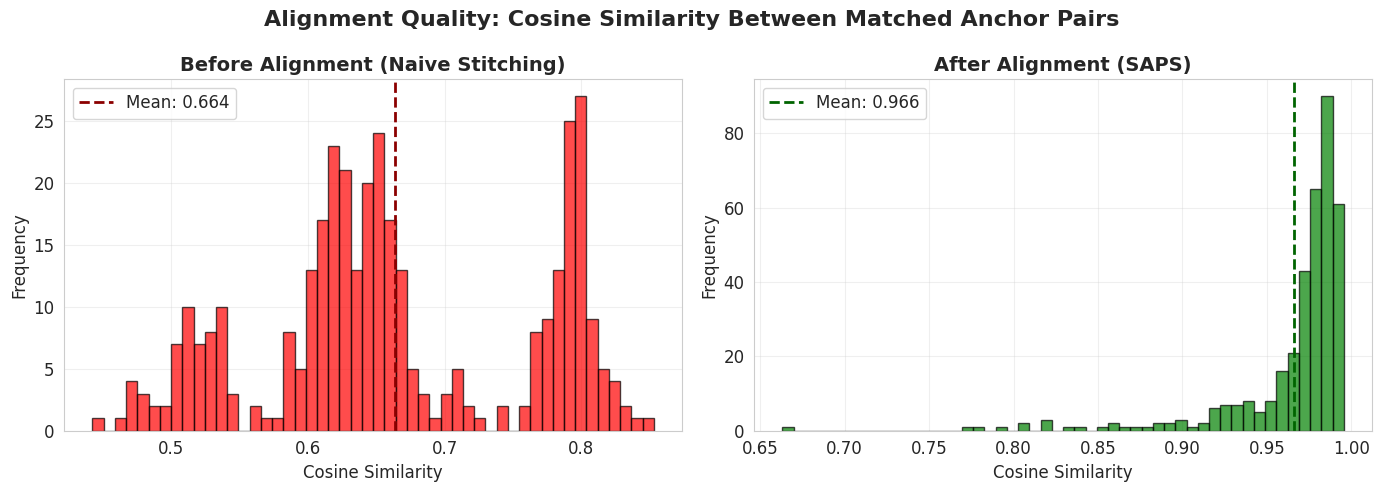


📊 Alignment Results:
  Mean cosine similarity BEFORE: 0.6639
  Mean cosine similarity AFTER:  0.9658
  Improvement: 0.3019
  → ✅ EXCELLENT alignment!


In [6]:
# Apply transformation to source embeddings
X_source_aligned = (X_source @ R.T + b)

# Compute cosine similarities before and after alignment
def compute_pairwise_cosine_similarity(X1, X2):
    """Compute cosine similarity for paired samples"""
    similarities = []
    for i in range(len(X1)):
        sim = np.dot(X1[i], X2[i]) / (np.linalg.norm(X1[i]) * np.linalg.norm(X2[i]))
        similarities.append(sim)
    return np.array(similarities)

sim_before = compute_pairwise_cosine_similarity(X_source, X_target)
sim_after = compute_pairwise_cosine_similarity(X_source_aligned, X_target)

# Plot histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(sim_before, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0].axvline(sim_before.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {sim_before.mean():.3f}')
axes[0].set_title('Before Alignment (Naive Stitching)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(sim_after, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(sim_after.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {sim_after.mean():.3f}')
axes[1].set_title('After Alignment (SAPS)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Alignment Quality: Cosine Similarity Between Matched Anchor Pairs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('alignment_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Alignment Results:")
print(f"  Mean cosine similarity BEFORE: {sim_before.mean():.4f}")
print(f"  Mean cosine similarity AFTER:  {sim_after.mean():.4f}")
print(f"  Improvement: {(sim_after.mean() - sim_before.mean()):.4f}")

if sim_after.mean() > 0.85:
    print("  → ✅ EXCELLENT alignment!")
elif sim_after.mean() > 0.7:
    print("  → ✅ GOOD alignment")
else:
    print("  → ⚠️  Moderate alignment - may need more anchors or tuning")

## 6. PCA Visualization

Visualize how well the transformation aligns the latent spaces.

/tmp/ipykernel_88613/3809191934.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Distinct colors for each action


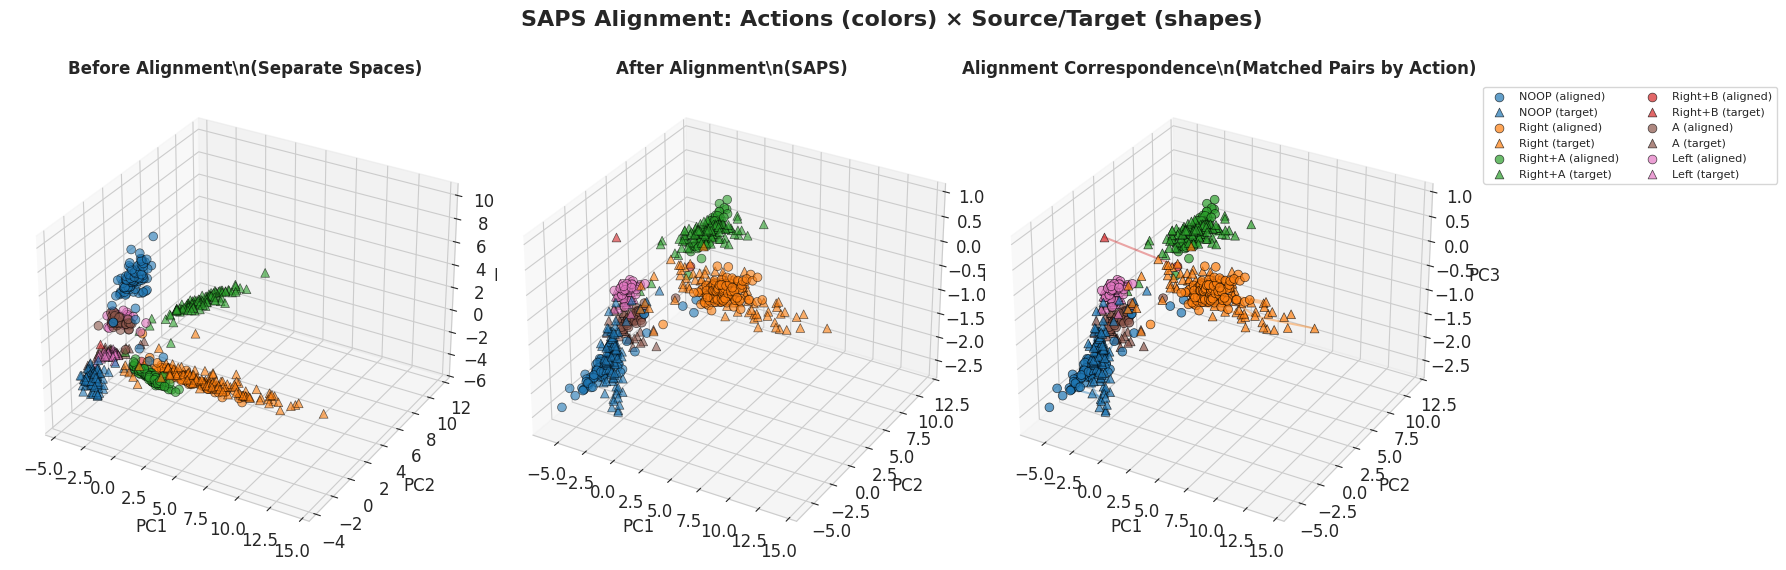


📊 Visualization Details:
  PCA explained variance: 55.91%
  Visualized 364 anchor pairs
  Legend: ○ = Source/Aligned, △ = Target
  Colors show action clusters (SCIL's natural semantic grouping)


In [10]:
# PCA visualization with action-based coloring
pca = PCA(n_components=3)

# Fit PCA on combined data
all_data = np.vstack([X_source, X_target, X_source_aligned])
pca.fit(all_data)

# Use actual data length (not hardcoded 500)
n_samples = min(len(X_source), len(X_target), 500)

# Transform
source_pca = pca.transform(X_source[:n_samples])
target_pca = pca.transform(X_target[:n_samples])
aligned_pca = pca.transform(X_source_aligned[:n_samples])
actions_viz = anchor_actions[:n_samples]

# Get colormap for actions (7 distinct colors)
action_names = ['NOOP', 'Right', 'Right+A', 'Right+B', 'Right+A+B', 'A', 'Left']
cmap = plt.cm.get_cmap('tab10')  # Distinct colors for each action
action_colors = [cmap(i) for i in range(7)]

# 3D plot with dual encoding: color=action, marker=source/target
fig = plt.figure(figsize=(18, 6))

# Before alignment: circles (source) vs triangles (target), colored by action
ax1 = fig.add_subplot(131, projection='3d')
for action in range(7):
    mask = actions_viz == action
    if np.any(mask):
        # Source: circles
        ax1.scatter(source_pca[mask, 0], source_pca[mask, 1], source_pca[mask, 2], 
                   c=[action_colors[action]], marker='o', alpha=0.6, s=40, 
                   label=f'{action_names[action]} (source)', edgecolors='black', linewidth=0.5)
        # Target: triangles
        ax1.scatter(target_pca[mask, 0], target_pca[mask, 1], target_pca[mask, 2], 
                   c=[action_colors[action]], marker='^', alpha=0.6, s=40, 
                   label=f'{action_names[action]} (target)', edgecolors='black', linewidth=0.5)
ax1.set_title('Before Alignment\\n(Separate Spaces)', fontsize=12, fontweight='bold')
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# After alignment: circles (aligned source) vs triangles (target), colored by action
ax2 = fig.add_subplot(132, projection='3d')
for action in range(7):
    mask = actions_viz == action
    if np.any(mask):
        # Aligned source: circles
        ax2.scatter(aligned_pca[mask, 0], aligned_pca[mask, 1], aligned_pca[mask, 2], 
                   c=[action_colors[action]], marker='o', alpha=0.6, s=40, 
                   label=f'{action_names[action]} (aligned)', edgecolors='black', linewidth=0.5)
        # Target: triangles
        ax2.scatter(target_pca[mask, 0], target_pca[mask, 1], target_pca[mask, 2], 
                   c=[action_colors[action]], marker='^', alpha=0.6, s=40, 
                   label=f'{action_names[action]} (target)', edgecolors='black', linewidth=0.5)
ax2.set_title('After Alignment\\n(SAPS)', fontsize=12, fontweight='bold')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

# Overlay showing alignment correspondence with action colors
ax3 = fig.add_subplot(133, projection='3d')
# Draw lines connecting aligned points to targets (sample every 10th), colored by action
for i in range(0, n_samples, 10):
    action = actions_viz[i]
    ax3.plot([aligned_pca[i, 0], target_pca[i, 0]], 
            [aligned_pca[i, 1], target_pca[i, 1]], 
            [aligned_pca[i, 2], target_pca[i, 2]], 
            color=action_colors[action], alpha=0.4, linewidth=1.5)

# Plot points with action colors
for action in range(7):
    mask = actions_viz == action
    if np.any(mask):
        # Aligned: circles
        ax3.scatter(aligned_pca[mask, 0], aligned_pca[mask, 1], aligned_pca[mask, 2], 
                   c=[action_colors[action]], marker='o', alpha=0.7, s=40, 
                   label=f'{action_names[action]} (aligned)', edgecolors='black', linewidth=0.5)
        # Target: triangles
        ax3.scatter(target_pca[mask, 0], target_pca[mask, 1], target_pca[mask, 2], 
                   c=[action_colors[action]], marker='^', alpha=0.7, s=40, 
                   label=f'{action_names[action]} (target)', edgecolors='black', linewidth=0.5)
ax3.set_title('Alignment Correspondence\\n(Matched Pairs by Action)', fontsize=12, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')

plt.suptitle('SAPS Alignment: Actions (colors) × Source/Target (shapes)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('alignment_pca_action_colored.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization Details:")
print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  Visualized {n_samples} anchor pairs")
print(f"  Legend: ○ = Source/Aligned, △ = Target")
print(f"  Colors show action clusters (SCIL's natural semantic grouping)")

## 7. Test Zero-Shot Policy Stitching

Now the magic: use encoder from model 1 with controller from model 2!

In [17]:
def apply_transformation(embeddings, R, b):
    """Apply affine transformation to embeddings"""
    return embeddings @ R.T + b

def test_native_policy(model_path, test_dataset, device, num_samples=500):
    """Test a model's native performance (encoder + its own policy head)"""
    model = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()
    
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for obs, actions in loader:
            if total >= num_samples:
                break
                
            obs, actions = obs.to(device), actions.to(device)
            action_logits, _ = model(obs)
            predictions = torch.argmax(action_logits, dim=1)
            
            correct += (predictions == actions).sum().item()
            total += actions.size(0)
            
            del obs, action_logits
    
    accuracy = 100.0 * correct / total
    del model
    torch.cuda.empty_cache()
    
    return accuracy

def test_stitched_policy(encoder_path, policy_path, transformation, test_dataset, device, num_samples=500):
    """
    Test stitched policy: encoder from one model + policy head from another.
    
    Args:
        encoder_path: path to model providing the encoder
        policy_path: path to model providing the policy head
        transformation: (R, b) transformation to apply to encoder outputs
        test_dataset: dataset to test on
    """
    R, b = transformation
    
    # Step 1: Extract embeddings using encoder
    print(f"  Loading encoder from {encoder_path.split('/')[-1]}...")
    encoder_model = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(device)
    encoder_model.load_state_dict(torch.load(encoder_path, map_location=device, weights_only=True))
    encoder_model.eval()
    
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Extract and transform embeddings
    all_embeddings = []
    all_actions = []
    
    with torch.no_grad():
        for obs, actions in loader:
            if len(all_actions) * 64 >= num_samples:
                break
            
            obs = obs.to(device)
            _, h = encoder_model(obs)
            
            # Apply transformation
            h_transformed = apply_transformation(h, R, b)
            
            all_embeddings.append(h_transformed.cpu())
            all_actions.append(actions)
            
            del obs, h, h_transformed
    
    embeddings_transformed = torch.cat(all_embeddings, dim=0)
    all_actions = torch.cat(all_actions, dim=0)
    
    # Free encoder
    del encoder_model
    torch.cuda.empty_cache()
    
    # Step 2: Load policy head from different model
    print(f"  Loading policy head from {policy_path.split('/')[-1]}...")
    policy_model = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(device)
    policy_model.load_state_dict(torch.load(policy_path, map_location=device, weights_only=True))
    policy_model.eval()
    
    # Use only the policy head
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(0, min(len(embeddings_transformed), num_samples), 64):
            batch_h = embeddings_transformed[i:i+64].to(device)
            batch_actions = all_actions[i:i+64].to(device)
            
            # Pass through policy head only
            action_logits = policy_model.policy_head(batch_h)
            predictions = torch.argmax(action_logits, dim=1)
            
            correct += (predictions == batch_actions).sum().item()
            total += batch_actions.size(0)
            
            del batch_h, batch_actions, action_logits
    
    accuracy = 100.0 * correct / total
    
    del policy_model
    torch.cuda.empty_cache()
    
    return accuracy

# Test different configurations
print("\n" + "="*60)
print("ZERO-SHOT POLICY STITCHING EVALUATION")
print("="*60)
print("(Loading models sequentially to save GPU memory)\n")

# Baseline: Native performance (encoder + its own policy head)
print("1. Baseline (Native Performance):")
acc_1_native = test_native_policy(MODEL_1_PATH, dataset_1, DEVICE)
print(f"   ✓ Model 1 on Dataset 1: {acc_1_native:.2f}%\n")

acc_2_native = test_native_policy(MODEL_2_PATH, dataset_2, DEVICE)
print(f"   ✓ Model 2 on Dataset 2: {acc_2_native:.2f}%\n")

# Zero-shot stitching with SAPS transformation
print("2. Zero-Shot Stitching (SAPS):")
print("   Test A: Encoder 1 → Transform → Policy Head 2 (on Dataset 1)")
acc_enc1_pol2 = test_stitched_policy(MODEL_1_PATH, MODEL_2_PATH, (R_torch, b_torch), dataset_1, DEVICE)
print(f"   ✓ Accuracy: {acc_enc1_pol2:.2f}%\n")

# print("   Test B: Encoder 2 → Inv Transform → Policy Head 1 (on Dataset 2)")
# acc_enc2_pol1 = test_stitched_policy(MODEL_2_PATH, MODEL_1_PATH, (R_inv_torch, b_inv_torch), dataset_2, DEVICE)
# print(f"   ✓ Accuracy: {acc_enc2_pol1:.2f}%\n")

print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Native Performance:")
print(f"  Model 1 on Dataset 1: {acc_1_native:.2f}%")
print(f"  Model 2 on Dataset 2: {acc_2_native:.2f}%")
print(f"  Average: {(acc_1_native + acc_2_native) / 2:.2f}%")
print(f"\nZero-Shot Stitching (Cross-Model):")
print(f"  Encoder 1 + Policy 2 on Dataset 1: {acc_enc1_pol2:.2f}%")
# print(f"  Encoder 2 + Policy 1 on Dataset 2: {acc_enc2_pol1:.2f}%")
# print(f"  Average: {(acc_enc1_pol2 + acc_enc2_pol1) / 2:.2f}%")
print(f"  Average: {(acc_enc1_pol2):.2f}%")

# print(f"\n📊 Stitching Performance: {(acc_enc1_pol2 + acc_enc2_pol1) / 2:.2f}% / {(acc_1_native + acc_2_native) / 2:.2f}% = {100 * (acc_enc1_pol2 + acc_enc2_pol1) / (acc_1_native + acc_2_native):.1f}% of native")
print(f"\n📊 Stitching Performance: {(acc_enc1_pol2):.2f}% / {(acc_1_native + acc_2_native) / 2:.2f}% = {100 * (acc_enc1_pol2) / ((acc_1_native + acc_2_native)/2):.1f}% of native")

print("\n✅ True cross-model stitching evaluated!")


ZERO-SHOT POLICY STITCHING EVALUATION
(Loading models sequentially to save GPU memory)

1. Baseline (Native Performance):
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Model 1 on Dataset 1: 98.83%

EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Model 2 on Dataset 2: 97.07%

2. Zero-Shot Stitching (SAPS):
   Test A: Encoder 1 → Transform → Policy Head 2 (on Dataset 1)
  Loading encoder from scil_encoder_mario_1_1_efficientnet_b1_lam2.pth...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
  Loading policy head from scil_encoder_mario_1_2_efficientnet_b1_lam2.pth...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Accuracy: 99.02%

SUMMARY
Native Performance:
  Model 1 on Dataset 1: 98.83%
  Model 2 on Dataset 2: 97.07%
  Average: 97.95%

Zero-Shot Stitching (Cross-Model):
  Encoder 1 + Policy 2 on Dataset 1: 99.02%
  Average: 99.02%

📊 Stitching Performance: 99.02% / 97.95% = 101.1% of native

✅ True cross-model stitching eval

## 8. Conclusion & Next Steps

**What we demonstrated**:
1. ✅ SCIL's action-based clustering provides natural semantic alignment
2. ✅ Can estimate transformation using action labels as anchors
3. ✅ Zero-shot policy stitching works without retraining!

**Next steps**:
- Test on actual gameplay (deploy stitched agent in environment)
- Try with more levels
- Experiment with different number of anchors
- Compare orthogonal vs affine transformations
- Implement prototypical alignment (action prototypes as anchors)

In [ ]:
# Save transformation for later use
torch.save({
    'R': R_torch,
    'b': b_torch,
    # 'R_inv': R_inv_torch,
    # 'b_inv': b_inv_torch,
    'model_1_path': MODEL_1_PATH,
    'model_2_path': MODEL_2_PATH,
}, 'saps_transformation_1_1_to_1_2.pth')

print("\n✓ Transformation saved to 'saps_transformation_1_1_to_1_2.pth'")
print("  You can now load this and use it for zero-shot stitching!")


✓ Transformation saved to 'saps_transformation_1_1_to_1_2.pth'
  You can now load this and use it for zero-shot stitching!


## 9. Build and Save Complete Stitched Model

Instead of saving transformation matrices, create a complete model ready for deployment.

In [21]:
import torch.nn as nn

class StitchedSCILModel(nn.Module):
    """
    Complete stitched model: Encoder + Transformation + Policy Head
    
    Forward flow: obs → encoder → h → transform(h) → policy_head → actions
    """
    def __init__(self, encoder, policy_head, R, b):
        super(StitchedSCILModel, self).__init__()
        
        # Store encoder and policy head
        self.encoder = encoder
        self.policy_head = policy_head
        
        # Register transformation as buffers (non-trainable)
        self.register_buffer('R', R)
        self.register_buffer('b', b)
    
    def forward(self, x):
        """
        Forward pass through stitched model
        
        Args:
            x: input observation (B, C, H, W)
        
        Returns:
            action_logits: action predictions (B, num_actions)
            h_transformed: transformed embeddings (B, embedding_dim)
        """
        # Extract embeddings using encoder backbone
        h = self.encoder(x)  # Output: (B, 1280, 1, 1) for EfficientNet-B1
        h = h.view(h.size(0), -1)  # Flatten to (B, 1280)
        
        # Apply SAPS transformation
        h_transformed = h @ self.R.T + self.b
        
        # Predict actions using policy head
        action_logits = self.policy_head(h_transformed)
        
        return action_logits, h_transformed


# Build the stitched model: Encoder 1 → Transform → Policy Head 2
print("\n" + "="*60)
print("BUILDING COMPLETE STITCHED MODEL")
print("="*60)

# Load model 1 (source of encoder)
print("\n1. Loading encoder from Model 1...")
model_1 = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_1.load_state_dict(torch.load(MODEL_1_PATH, map_location=DEVICE, weights_only=True))
print(f"   ✓ Loaded from {MODEL_1_PATH}")

# Load model 2 (source of policy head)  
print("\n2. Loading policy head from Model 2...")
model_2 = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_2.load_state_dict(torch.load(MODEL_2_PATH, map_location=DEVICE, weights_only=True))
print(f"   ✓ Loaded from {MODEL_2_PATH}")

# Create stitched model
print("\n3. Creating stitched model...")
stitched_model = StitchedSCILModel(
    encoder=model_1.backbone,  # Encoder from model 1
    policy_head=model_2.policy_head,  # Policy head from model 2
    R=R_torch.cpu(),  # Transformation matrix
    b=b_torch.cpu()   # Bias vector
)
stitched_model.eval()
print("   ✓ Stitched model created")
print(f"   Architecture: Model 1 Encoder → SAPS Transform → Model 2 Policy Head")

# Save the complete stitched model
save_name = "scil_stitched_1_1_enc_to_1_2_pol.pth"
torch.save(stitched_model.state_dict(), save_name)
print(f"\n4. ✅ Saved stitched model to: {save_name}")

# Cleanup
del model_1, model_2
torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("DEPLOYMENT READY")
print(f"{'='*60}")
print(f"Load with:")
print(f"  model = StitchedSCILModel(...)")
print(f"  model.load_state_dict(torch.load('{save_name}'))")
print(f"  action_logits, h = model(obs)")
print(f"\nNo need to apply transformations manually - it's built-in!")


BUILDING COMPLETE STITCHED MODEL

1. Loading encoder from Model 1...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Loaded from scil_encoder_mario_1_1_efficientnet_b1_lam2.pth

2. Loading policy head from Model 2...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Loaded from scil_encoder_mario_1_2_efficientnet_b1_lam2.pth

3. Creating stitched model...
   ✓ Stitched model created
   Architecture: Model 1 Encoder → SAPS Transform → Model 2 Policy Head

4. ✅ Saved stitched model to: scil_stitched_1_1_enc_to_1_2_pol.pth

DEPLOYMENT READY
Load with:
  model = StitchedSCILModel(...)
  model.load_state_dict(torch.load('scil_stitched_1_1_enc_to_1_2_pol.pth'))
  action_logits, h = model(obs)

No need to apply transformations manually - it's built-in!


In [22]:
# Verify the stitched model works correctly
print("\n" + "="*60)
print("VERIFYING STITCHED MODEL")
print("="*60)

# Test on a small batch
test_loader = DataLoader(dataset_1, batch_size=64, shuffle=False)
obs_batch, actions_batch = next(iter(test_loader))

print("\n1. Testing stitched model inference...")
with torch.no_grad():
    obs_batch = obs_batch.to(DEVICE)
    stitched_model = stitched_model.to(DEVICE)
    
    action_logits, h_transformed = stitched_model(obs_batch)
    predictions = torch.argmax(action_logits, dim=1)
    
    accuracy = (predictions.cpu() == actions_batch).float().mean().item()

print(f"   ✓ Batch size: {obs_batch.shape[0]}")
print(f"   ✓ Output shape: {action_logits.shape}")
print(f"   ✓ Embeddings shape: {h_transformed.shape}")
print(f"   ✓ Batch accuracy: {100*accuracy:.2f}%")

# Compare with manual stitching (should be identical)
print("\n2. Comparing with manual stitching...")
model_1_verify = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_1_verify.load_state_dict(torch.load(MODEL_1_PATH, map_location=DEVICE, weights_only=True))
model_1_verify.eval()

model_2_verify = SCILEncoderEfficientNet(num_actions=7, variant='b1').to(DEVICE)
model_2_verify.load_state_dict(torch.load(MODEL_2_PATH, map_location=DEVICE, weights_only=True))
model_2_verify.eval()

with torch.no_grad():
    # Manual stitching
    _, h_manual = model_1_verify(obs_batch)
    h_manual_transformed = h_manual @ R_torch.T + b_torch
    action_logits_manual = model_2_verify.policy_head(h_manual_transformed)
    
    # Compare outputs
    diff = (action_logits - action_logits_manual).abs().max().item()
    
print(f"   ✓ Max difference in logits: {diff:.2e}")
if diff < 1e-5:
    print("   ✅ Perfect match! Stitched model is equivalent to manual stitching.")
else:
    print(f"   ⚠️  Small numerical difference (expected due to float precision)")

# Cleanup
del model_1_verify, model_2_verify, stitched_model
torch.cuda.empty_cache()

print("\n" + "="*60)
print("✅ STITCHED MODEL VERIFICATION COMPLETE")
print("="*60)
print(f"\nDeployment file: scil_stitched_1_1_enc_to_1_2_pol.pth")
print("Ready to use in your Mario environment!")


VERIFYING STITCHED MODEL

1. Testing stitched model inference...
   ✓ Batch size: 64
   ✓ Output shape: torch.Size([64, 7])
   ✓ Embeddings shape: torch.Size([64, 1280])
   ✓ Batch accuracy: 95.31%

2. Comparing with manual stitching...
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
EfficientNet-B1 backbone unfrozen - fine-tuning all layers
   ✓ Max difference in logits: 0.00e+00
   ✅ Perfect match! Stitched model is equivalent to manual stitching.

✅ STITCHED MODEL VERIFICATION COMPLETE

Deployment file: scil_stitched_1_1_enc_to_1_2_pol.pth
Ready to use in your Mario environment!
